In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
# Function Definitions

def sine_gaussian_waveform(t, A, t0, tau, f0, phi0):
    gaussian_envelope = A * np.exp(-((t - t0)**2) / (2 * tau**2))
    sine_wave = np.cos(2 * np.pi * f0 * t + phi0)
    return gaussian_envelope * sine_wave

def add_glitches(signal, glitch_frequency, glitch_amplitude, glitch_duration, num_points):
    signal_with_glitches = signal.copy()
    for _ in range(int(glitch_frequency * num_points)):
        start_idx = np.random.randint(0, num_points - glitch_duration)
        end_idx = start_idx + glitch_duration
        glitch = np.random.uniform(-glitch_amplitude, glitch_amplitude, glitch_duration)
        signal_with_glitches[start_idx:end_idx] += glitch
    return signal_with_glitches



def generate_waveform_data(num_samples, num_points, A_base, A_variation, t0_base, t0_variation, tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, time_length_base, time_length_variation, glitch_frequency=0.0, glitch_amplitude=0.0, glitch_duration=0, signal_present=True):
    data = [] 
    labels = []
    signal_params = []

    for _ in range(num_samples):
        A = A_base + np.random.uniform(-A_variation, A_variation)
        t0 = t0_base + np.random.uniform(-t0_variation, t0_variation)
        f0 = f0_base + np.random.uniform(-f0_variation, f0_variation)
        noise_level = noise_level_base + np.random.uniform(-noise_variation, noise_variation)
        time_length = time_length_base + np.random.uniform(-time_length_variation, time_length_variation)
        
        t = np.linspace(0, time_length, num_points)

        if signal_present:
            waveform = sine_gaussian_waveform(t, A, t0, tau, f0, phi0)
            signal_with_noise = waveform+noise_level
            label = np.zeros_like(t)
            signal_start = np.argmin(np.abs(t - t0 + 3 * tau))
            signal_end = np.argmin(np.abs(t - t0 - 3 * tau))
            label[signal_start:signal_end] = 1
        else:
            signal_with_noise = np.random.uniform(-noise_level, noise_level, t.shape)
            label = np.zeros_like(t)

        if glitch_frequency > 0:
            signal_with_noise = add_glitches(signal_with_noise, glitch_frequency, glitch_amplitude, glitch_duration, num_points)
        
        features = signal_with_noise
        data.append(features)
        labels.append(label)
        signal_params.append((t0,A,t,f0)) # Save parameters for later use
    
    return np.array(data), np.array(labels), signal_params

def generate_coincidence_test_data(num_points,test_data, test_labels, signal_params, noise_level_coincidence, noise_variation_coincidence, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, signal_probability=0.5):
    coincident_data = []
    coincident_labels = []
    l=1
    t0=0.5
    f0=500
    A_base = 15e-22
    A_variation = 10e-22
    t0_base = 0.5
    t0_variation = 0.3
    tau = 0.05
    f0_base = 500
    f0_variation = 300
    phi0 = 0.0
    noise_level_base = 0
    noise_variation =0
    time_length_base = 1.0
    time_length_variation = 0.3

    for i in range(test_data.shape[0]):
        noise_level = noise_level_base + np.random.uniform(-noise_variation, noise_variation)
        time_length = time_length_base + np.random.uniform(-time_length_variation, time_length_variation)
        if signal_params[i] is not None:
           
            t0 ,A,t,f0= signal_params[i]  # Retrieve parameters for the current sample
            
            if np.random.random()<signal_probability:
                # Generate data with a signal
             
                waveform = sine_gaussian_waveform(t, A, t0, tau, f0, phi0)
                # Add noise
                noise_level = noise_level_coincidence + np.random.uniform(-noise_variation_coincidence, noise_variation_coincidence)
                signal_with_noise =  noise_level + waveform

                # Add glitches
                if glitch_frequency_coincidence > 0:
                    signal_with_glitches = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, len(signal_with_noise))
                
                coincident_data.append(signal_with_glitches)
                coincident_labels.append(test_labels[i])
            else:
            
                # Generate pure noise with glitches
                noise_level = noise_level_coincidence + np.random.uniform(-noise_variation_coincidence, noise_variation_coincidence)
                signal_with_noise = np.random.uniform(-noise_level, noise_level, len(test_data[i]))

                if glitch_frequency_coincidence > 0:
                    signal_with_glitches = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, len(signal_with_noise))
                
                label = np.zeros_like(signal_with_noise)
                coincident_data.append(signal_with_glitches)
                coincident_labels.append(label)
        else:
            # Handle None cases by generating pure noise with glitches
            noise_level = noise_level_coincidence + np.random.uniform(-noise_variation_coincidence, noise_variation_coincidence)
            signal_with_noise = np.random.uniform(-noise_level, noise_level, len(test_data[i]))

            if glitch_frequency_coincidence > 0:
                signal_with_glitches = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, len(signal_with_noise))
            
            label = np.zeros_like(signal_with_noise)
            coincident_data.append(signal_with_glitches)
            coincident_labels.append(label)

    return np.array(coincident_data), np.array(coincident_labels) 

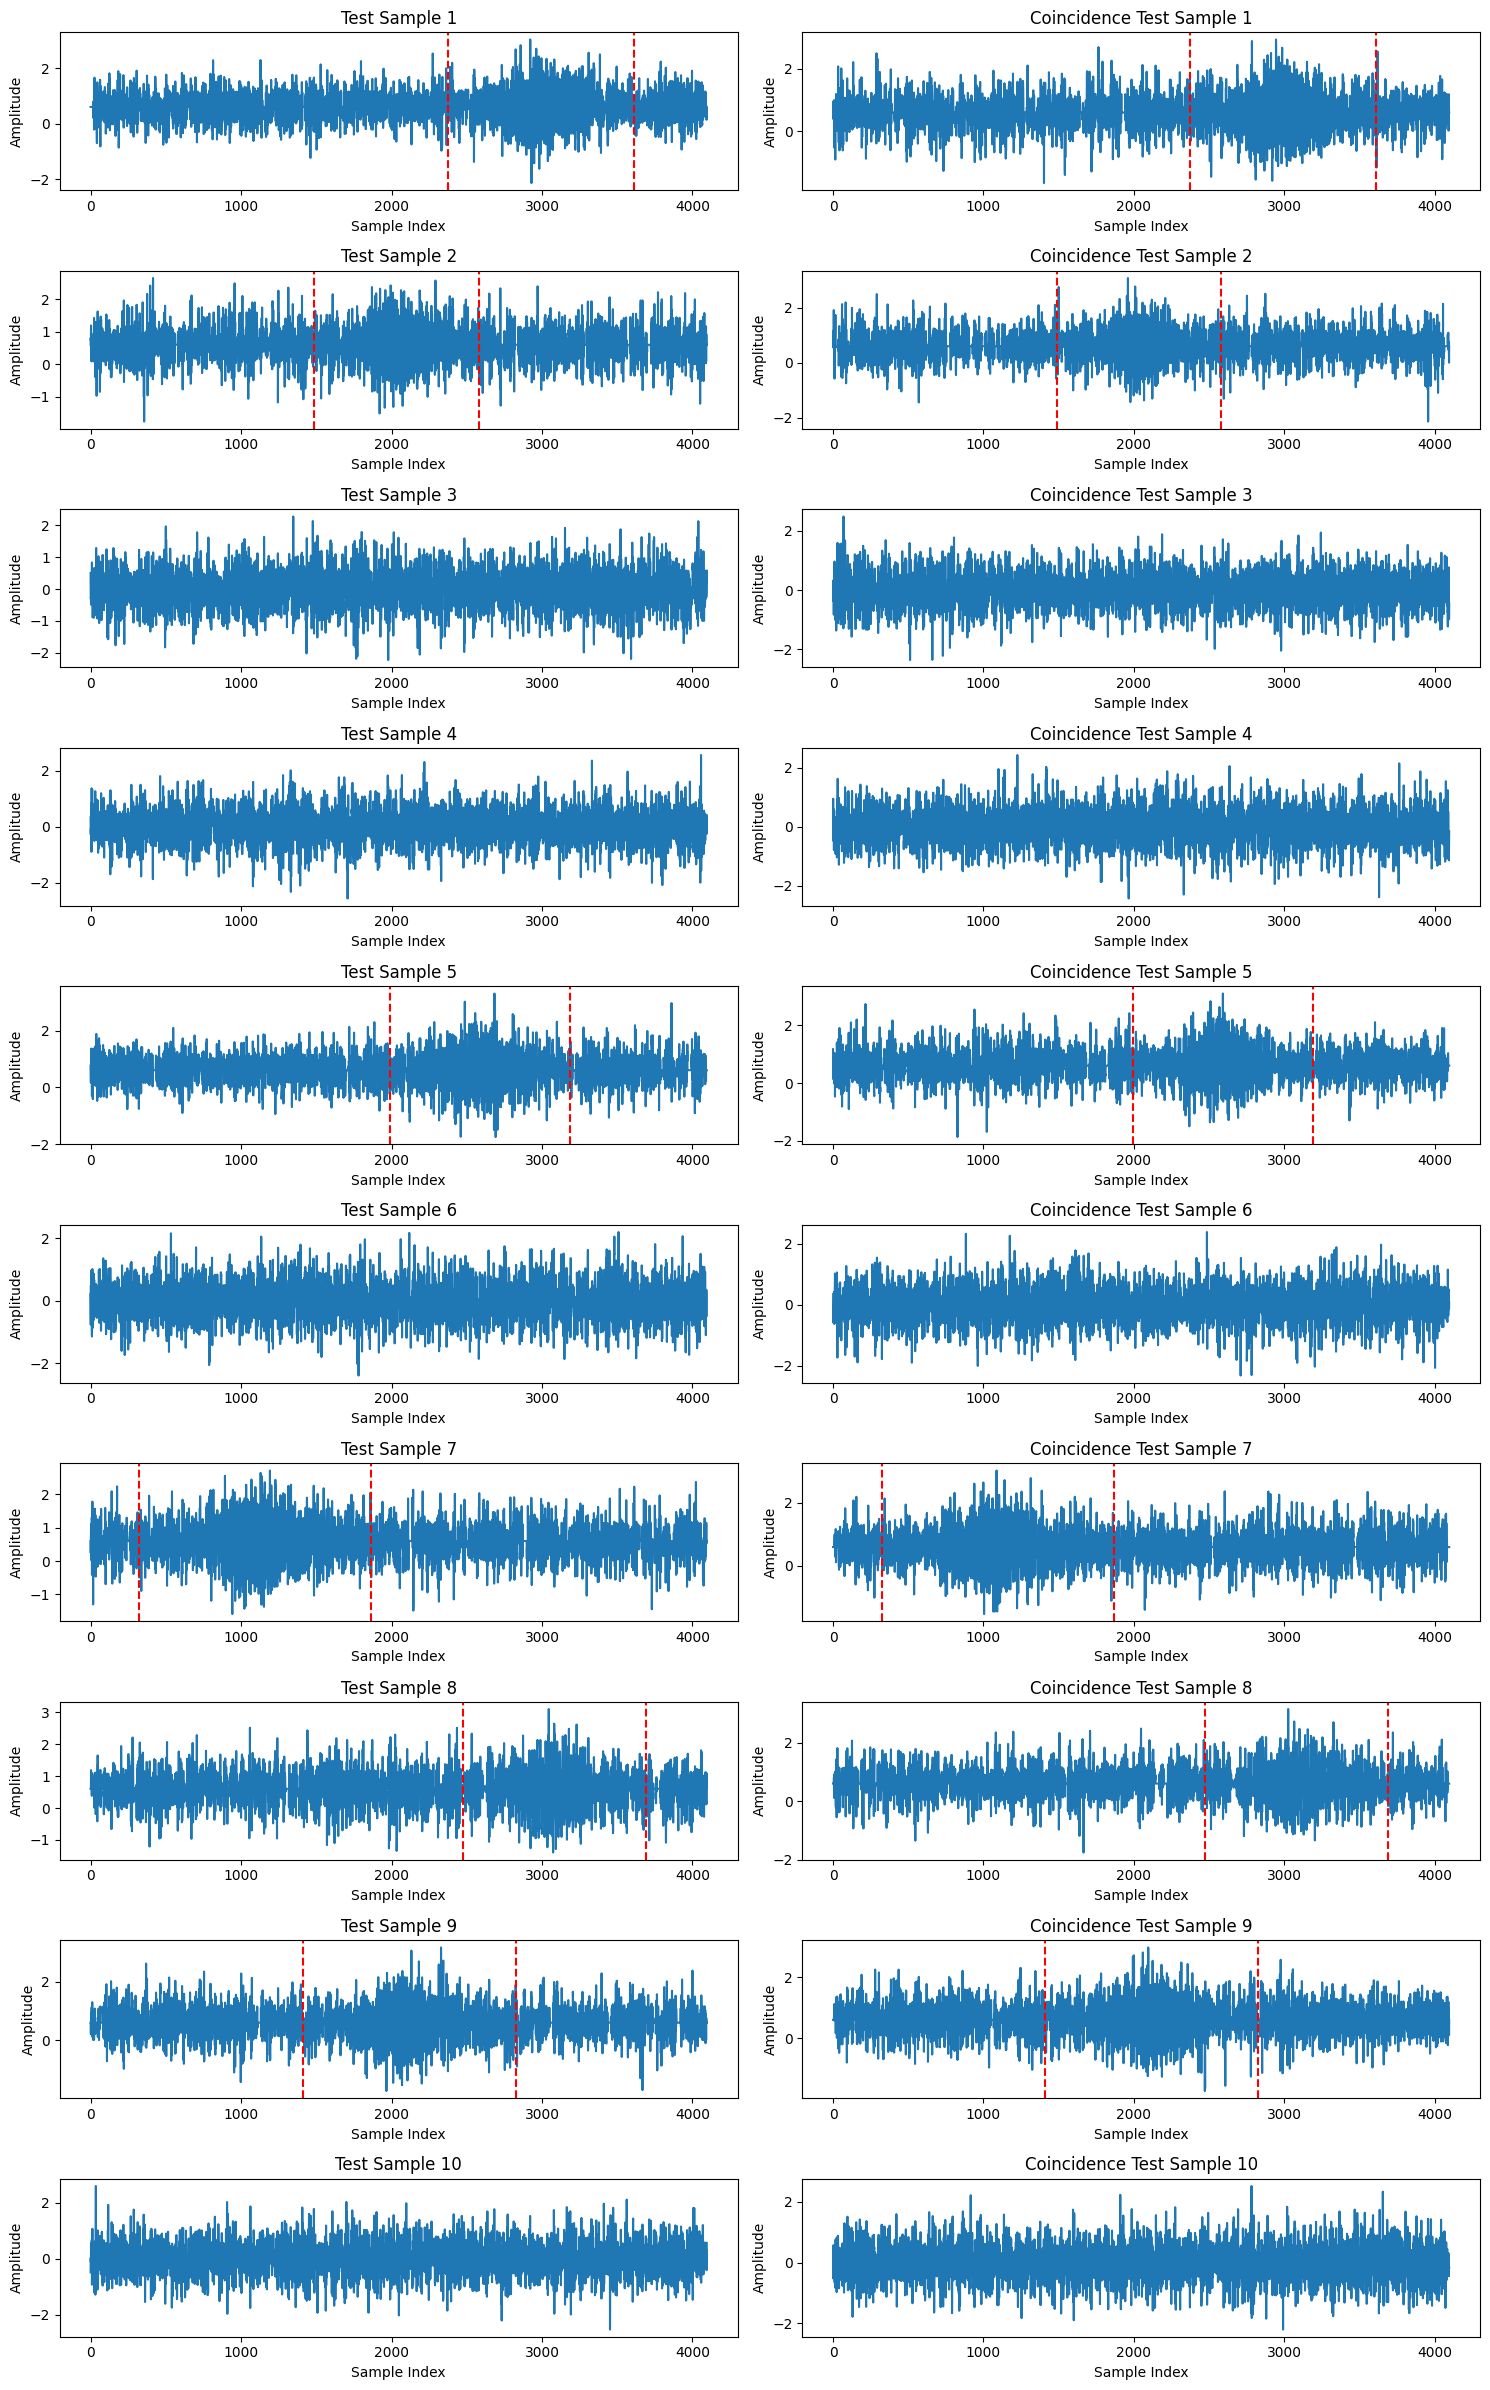

In [4]:
# Parameters for waveform generation
num_samples_per_class = 20
num_points = 4096

A_base = 6e-22
A_variation = 0e-22
t0_base = 0.5
t0_variation = 0.3
tau = 0.05
f0_base = 500
f0_variation = 300
phi0 = 0.0
noise_level_base = 3e-22
noise_variation = 0
time_length_base = 1.0
time_length_variation = 0.3

glitch_frequency = 0.2
glitch_amplitude = 3e-22
glitch_duration = 10

# Generate data with and without signal
data_with_signal, labels_with_signal, signal_params_with_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
    signal_present=True
)

data_without_signal, labels_without_signal, _ = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
    signal_present=False
)

# Combine and shuffle data and labels
data = np.concatenate([data_with_signal, data_without_signal])
labels = np.concatenate([labels_with_signal, labels_without_signal])
signal_params = signal_params_with_signal + [None] * num_samples_per_class  # Add None for samples without signal

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
signal_params = [signal_params[i] for i in indices]

data = data / (5e-22)  # Normalize

# Split data into training and test sets
X_train, X_test, y_train, y_test, signal_params_train, signal_params_test = train_test_split(data, labels, signal_params, test_size=0.5, random_state=42)

# Generate coincident test data with 50% signal probability and distinct glitches and noise
glitch_frequency_coincidence = 0.2
glitch_amplitude_coincidence = 3e-22
glitch_duration_coincidence = 10


signal_probability = 1

coincidence_test_data, coincidence_test_labels = generate_coincidence_test_data(num_points,
    X_test, y_test, signal_params_test, noise_level_base, noise_variation, 
    glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence,
    signal_probability=signal_probability)

coincidence_test_data=coincidence_test_data/ (5e-22)
# Save data and labels to CSV files
def save_to_csv(data, labels, prefix):
    pd.DataFrame(data).to_csv(f'{prefix}_data.csv', index=False)
    pd.DataFrame(labels).to_csv(f'{prefix}_labels.csv', index=False)

save_to_csv(coincidence_test_data, coincidence_test_labels, 'coincidence_test')

save_to_csv(X_train.T, y_train.T, 'train')
save_to_csv(X_test.T, y_test.T, 'test')
save_to_csv(coincidence_test_data.T, coincidence_test_labels.T, 'coincidence_test')


# Plotting function for side-by-side comparison
def plot_samples_side_by_side(samples1, labels1, samples2, labels2, title_prefix1, title_prefix2, num_samples=10):
    plt.figure(figsize=(15, 24))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.plot(samples1[i])
        plt.title(f'{title_prefix1} Sample {i+1}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        if np.any(labels1[i] == 1):
            signal_region = np.where(labels1[i] == 1)[0]
            if len(signal_region) > 0:
                plt.axvline(x=signal_region[0], color='r', linestyle='--')
                plt.axvline(x=signal_region[-1], color='r', linestyle='--')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.plot(samples2[i])
        plt.title(f'{title_prefix2} Sample {i+1}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        if np.any(labels2[i] == 1):
            signal_region = np.where(labels2[i] == 1)[0]
            if len(signal_region) > 0:
                plt.axvline(x=signal_region[0], color='r', linestyle='--')
                plt.axvline(x=signal_region[-1], color='r', linestyle='--')

    

    plt.tight_layout()
    plt.show()

# Example usage of plotting function
plot_samples_side_by_side(X_test[:10], y_test[:10], coincidence_test_data[:10], coincidence_test_labels[:10], 'Test', 'Coincidence Test')